## Mining

This notebook shows how the mining method works. The code is taken from the mining() function.

In [1]:
import gefolki

In [2]:
!mkdir ./datasets
!wget "https://raw.githubusercontent.com/aplyer/gefolki/master/datasets/JacksonvilleNavalAirStation_sandiaKu.png" -P datasets
!wget "https://raw.githubusercontent.com/aplyer/gefolki/master/datasets/S1_Jacksonville_GEE.tif" -P datasets
#  'JacksonvilleNavalAirStation_sandiaKu is Courtesy of Sandia National Laboratories, Radar ISR'

--2019-11-21 16:19:25--  https://raw.githubusercontent.com/aplyer/gefolki/master/datasets/JacksonvilleNavalAirStation_sandiaKu.png
Resolving raw.githubusercontent.com... 151.101.192.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202939 (198K) [image/png]
Saving to: “datasets/JacksonvilleNavalAirStation_sandiaKu.png”

100%[======================================>] 202,939     --.-K/s   in 0.02s   

2019-11-21 16:19:26 (8.30 MB/s) - “datasets/JacksonvilleNavalAirStation_sandiaKu.png” saved [202939/202939]

--2019-11-21 16:19:26--  https://raw.githubusercontent.com/aplyer/gefolki/master/datasets/S1_Jacksonville_GEE.tif
Resolving raw.githubusercontent.com... 151.101.192.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9079247 (8.7M) [application/o

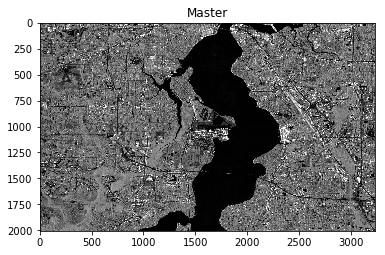

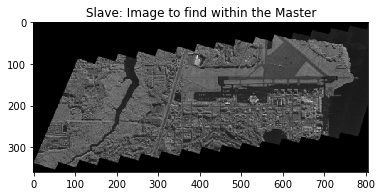

In [4]:
import numpy as np
from skimage.io import imread
import pylab as pl

M = imread("datasets/S1_Jacksonville_GEE.tif")
pl.figure()
pl.imshow(M)
pl.title('Master')
pl.show()

  
S = imread("datasets/JacksonvilleNavalAirStation_sandiaKu.png")
pl.figure()
pl.imshow(S)
pl.title('Slave: Image to find within the Master')  
pl.show()

In [5]:
Master=M[:,:,0];
Slave=S[:,:,0];
dimx,dimy=np.shape(Master);
dimxn,dimyn=np.shape(Slave);

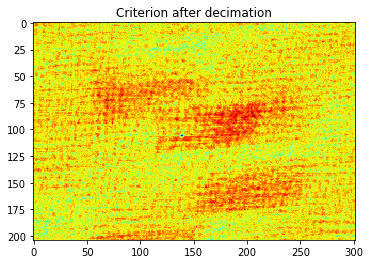

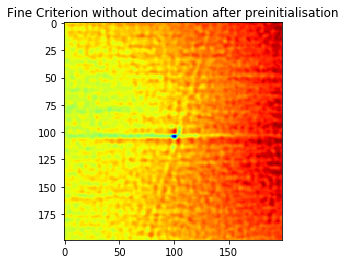

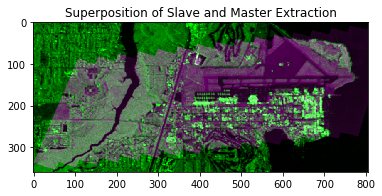

In [8]:
fdecimation = 8
rank = 4

# Decimation
from skimage.transform import resize
nx = int(round(dimx/fdecimation)) 
ny = int(round(dimy/fdecimation))
Mg = resize(Master,(nx, ny),1,'constant')
nsx = int(round(dimxn/fdecimation)) 
nsy = int(round(dimyn/fdecimation))
Sg = resize(Slave,(nsx, nsy),1,'constant')       

# Rank computation and Criterion on images after deximation
from gefolki import rank_filter_sup
from gefolki import rank_filter_inf
Mg_rank = rank_filter_inf(Mg, rank) # rank sup : high value pixels have low rank
Sg_rank = rank_filter_inf(Sg, rank)
                 
R=np.zeros((nx-nsx-1,ny-nsy-1)); 
indices=np.nonzero(Sg_rank);
test2=Sg_rank[indices];

for k in range(0,nx-nsx-1):
    for p in range(0,ny-nsy-1):
        test1=Mg_rank[k:k+nsx,p:p+nsy];
        test1=test1[indices];
        test=(test1-test2)**2
        R[k,p]=test.mean();  
        
pl.figure()
pl.imshow(R,vmin=np.min(R[np.nonzero(R)]),vmax=R.max(),cmap='jet')
pl.title('Criterion after decimation')  
pl.show()
  
ind = np.unravel_index(np.argmin(R, axis=None), R.shape)
indx=(ind[0]*fdecimation)
indy=(ind[1]*fdecimation)

# Rank computation and Criterion on images without deximation after preinitialization
Master_crop = Master[indx-100:indx+dimxn+100,indy-100:indy+dimyn+100]
M_rank_crop = rank_filter_inf(Master_crop, rank) # rank sup : high value pixels have low rank
S_rank = rank_filter_inf(Slave, rank)

dimxcrop,dimycrop=np.shape(M_rank_crop);
Rfin=np.zeros((dimxcrop-dimxn-1,dimycrop-dimyn-1)); 
indices=np.nonzero(S_rank);
test2=S_rank[indices];

for k in range(0,dimxcrop-dimxn-1):
    for p in range(0,dimycrop-dimyn-1):
        test1=M_rank_crop[k:k+dimxn,p:p+dimyn];
        test1=test1[indices];
        test=(test1-test2)**2
        Rfin[k,p]=test.mean();
        
# Final Extraction
ind = np.unravel_index(np.argmin(Rfin, axis=None), Rfin.shape)
indx=(ind[0])
indy=(ind[1])
Master_final = Master_crop[indx:indx+dimxn,indy:indy+dimyn];

pl.figure()
pl.imshow(Rfin,vmin=np.min(Rfin[np.nonzero(Rfin)]),vmax=Rfin.max(),cmap='jet')
pl.title('Fine Criterion without decimation after preinitialisation')  
pl.show()


rgb = np.dstack((Slave,Master_final,Slave))

pl.figure()
pl.imshow(rgb)
pl.title('Superposition of Slave and Master Extraction')
pl.show()